# Modelo de Regresión Simple

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

## Descripción Previa de la Base de Datos

Resumen Numérico

In [3]:
pdf4 = bd5.sample(False, 0.1, 0).select('DEST','Horario','ARR_DELAY',
                                        'DEP_DELAY','RetrasoNeto').toPandas()
pdf4.corr()

,Horario,ARR_DELAY,DEP_DELAY,RetrasoNeto
Horario,1.000000,0.087638,0.081273,0.044104
ARR_DELAY,0.087638,1.000000,0.973316,0.313102
DEP_DELAY,0.081273,0.973316,1.000000,0.086816
RetrasoNeto,0.044104,0.313102,0.086816,1.000000


Resumen Gráfico

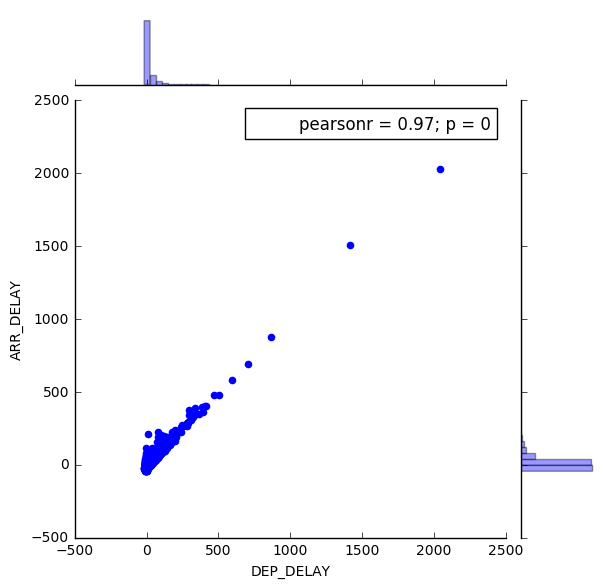

In [4]:
import seaborn as sns
%matplotlib inline
sns.jointplot(x="DEP_DELAY", y="ARR_DELAY", data=pdf4)

## Configuración de la base de datos

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

assembler = VectorAssembler(
    inputCols=['DEP_DELAY'],
    outputCol='features')

bd6 = assembler.transform(bd5).select(col("ARR_DELAY").alias("label"),'features')
bd6.show()

+-----+--------+
|label|features|
+-----+--------+
|-19.0|  [-8.0]|
|  7.0|   [6.0]|
|-12.0|  [-5.0]|
|-14.0|  [-6.0]|
|-15.0|  [-5.0]|
|  0.0|  [-5.0]|
|-23.0|  [-8.0]|
|-16.0|  [-6.0]|
| -3.0|  [-3.0]|
|  3.0|  [-6.0]|
|-16.0| [-11.0]|
|-11.0|   [0.0]|
|  0.0|   [1.0]|
| -4.0|   [2.0]|
|  3.0|  [-9.0]|
| -7.0|   [5.0]|
| 18.0|   [7.0]|
|-10.0|  [-4.0]|
|-15.0|  [-2.0]|
|-19.0|  [-7.0]|
+-----+--------+
only showing top 20 rows



### Ajuste del modelo

In [6]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()
model = lr.fit(bd6)
pred = model.transform(bd6)

/usr/lib/spark/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


Coeficientes

In [7]:
print(model.intercept,model.coefficients)

-4.3994410804913295 [1.02786002478]


Modelo Teórico:

__ArrDelay = $\beta_0$ + $\beta_1$*DepDelay + $\epsilon$__ 


Modelo Predictivo:

__ArrDelay = -4.4 + 1.03*DepDelay__




Valores Predichos y Residuos

In [8]:
pred = pred.withColumn('residual', pred.label-pred.prediction)
pred.show()

+-----+--------+-------------------+--------------------+
|label|features|         prediction|            residual|
+-----+--------+-------------------+--------------------+
|-19.0|  [-8.0]|-12.622321278697306| -6.3776787213026935|
|  7.0|   [6.0]| 1.7677190681631538|   5.232280931836846|
|-12.0|  [-5.0]| -9.538741204370066| -2.4612587956299343|
|-14.0|  [-6.0]|-10.566601229145814|  -3.433398770854186|
|-15.0|  [-5.0]| -9.538741204370066|  -5.461258795629934|
|  0.0|  [-5.0]| -9.538741204370066|   9.538741204370066|
|-23.0|  [-8.0]|-12.622321278697306| -10.377678721302694|
|-16.0|  [-6.0]|-10.566601229145814|  -5.433398770854186|
| -3.0|  [-3.0]| -7.483021154818571|   4.483021154818571|
|  3.0|  [-6.0]|-10.566601229145814|  13.566601229145814|
|-16.0| [-11.0]|-15.705901353024547|-0.29409864697545274|
|-11.0|   [0.0]|-4.3994410804913295| -6.6005589195086705|
|  0.0|   [1.0]|-3.3715810557155823|  3.3715810557155823|
| -4.0|   [2.0]| -2.343721030939835|  -1.656278969060165|
|  3.0|  [-9.0

Representación gráfica de resultados

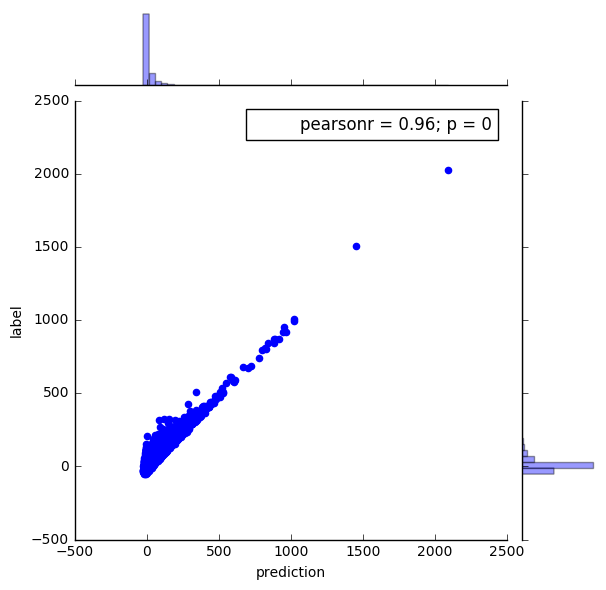

In [9]:
pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="label", data=pdpred)

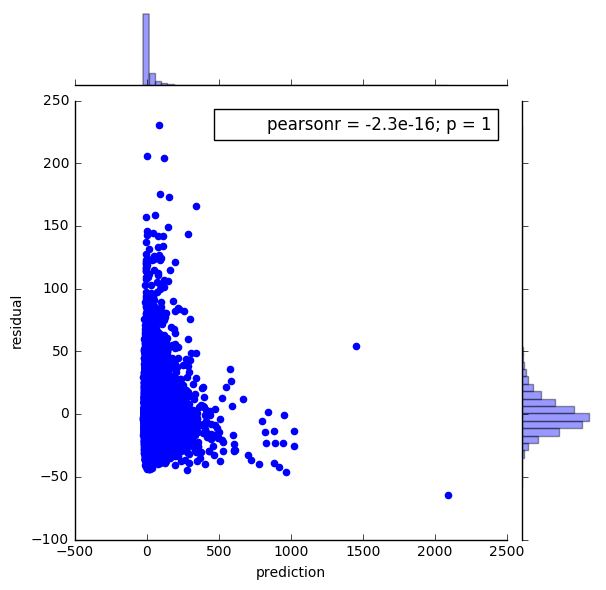

In [10]:
sns.jointplot(x="prediction", y="residual", data=pdpred)

Métricas de Evaluación (R2, RMSE, MAE)

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="rmse").evaluate(pred))
print(RegressionEvaluator(metricName="r2").evaluate(pred))


15.498421344920349
0.9161065747950505


Otros parámetros opcionales del modelo

In [10]:
#lr = LinearRegression()
#lr = LinearRegression(
    #maxIter=5, 
    #regParam=0.0,
    #elasticNetParam=0.0,
    #solver="normal", 
    #weightCol="weight")